# Tearing reconnaissance

Le principe est de trouver où se trouve le problème grâce à l'histogramme, s'assurer que c'est bien un problème de tearing, puis le réparer.

Lancer le [pipeline](#Pipeline-final)

**Trouver la zone de tearing :**

    - crop une colonne de 50px
    - grise l'image
    - cap les couleurs sur 0-255
    - créé l'histogramme de la colonne
    - selectionner la zone à 10 lignes près de la valeur max (qui correspond à un pic de noir)
    - faire des batchs de 3px, faire la moyenne de ces px
    - comparer les batchs avec ceux de la ligne en dessous 
        => array de différences entre lignes
        => moy 
    - on garde le top 2 du tableau, H1 et H2, ce qui correspond à la zone teared
    
**Vérifier si c'est vraiment ou non un tearing**

On se base sur :

    - le % de différence entre H1 et H2 
    - Le % de la médiane et du plus grand entre H1 et H2 est trop grand

Si les H1-H2 sont proches mais trop proches de la madiane, on estime que l'image n'est pas assez variée, c'est donc probablement un faux positif.

**Réaparation du tearing**

Une fois la zone teared trouvée, on peut appliquer une reconnaissance de l'angle de skewing, ce qui nous permettra de rotate le fragment de l'image par l'angle de décalage, puis le fusionner à son image originale.

In [712]:
import sys
import os
import random
import statistics
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image, ImageStat, ImageDraw
import base_functions as bfun

In [713]:
DATASET_PATH = os.path.join(os.getcwd(), "../datasets/dataset_clean_degraded/degraded")
CSV_PATH = os.path.join("..", "dataset_problems.csv")
random.seed(42)

## Création d'histogramme

Sachant qu'il y a toujours une grosse marque noir sur le coté gauche de l'image, on fait un histogramme de répartition des couleurs uniquement sur cette partie, pour augmenter les chances de trouver la marque, en ignorant le reste de l'image (qui pourrait être noire)
        
- crop une colonne de 50px
- grise l'image
- cap les couleurs sur 0-255
- créé l'histogrammem

**Fonctions utilisées par le pipeline**

In [714]:
def _createVerticalBox(img):
    width, height = img.size
    x1 = 0
    y1 = 0 
    x2 = 50
    y2 = height 
    box = (x1, y1, x2, y2)
    return box

def _grayImage(img):
    img_gray = np.zeros((img.shape[0], img.shape[1], img.shape[2]), dtype = 'uint8')
    img_gray[:,:,0] = np.mean(img, axis = 2)
    img_gray[:,:,1] = img_gray[:,:,0]
    img_gray[:,:,2] = img_gray[:,:,0]
    return img_gray

def _capColors(img_gray):
    img_min = np.min(img_gray)
    img_max = np.max(img_gray)
    img_transform = (img_gray - img_min) * 255.0 / (img_max - img_min)
    img_transform = img_transform.astype('uint8')
    return img_transform
    
def _createHist(img, threshold):
    mask = np.where((img[:,:,0] < threshold) & (img[:,:,1] < threshold) & (img[:,:,2] < threshold), 1, 0)
    hist = np.sum(mask, axis=1)
    return hist

**Pipeline Histogramme**

In [724]:
def _histLeftColumn(img):
    #Vertical box pour prendre qu'une partie de l'image
    box = _createVerticalBox(img)
    leftColumn = img.crop(box)
    
    #Griser la colonne
    arrayImg = np.asarray(leftColumn, dtype="int32")
    grayLeftColumn = _grayImage(arrayImg)
    grayLeftColumn = _capColors(grayLeftColumn)
    
    #Créer l'histogramme
    hist = _createHist(grayLeftColumn, 5)
#     plt.plot(hist)
    return hist

## Reconnaissance du tearing

Il faut dans un premier temps isoler la zone teared afin de la réparer.
Pour ce faire:

    - on trouve la valeur la plus haute dans l'histogramme (correspond à une forte présence de noir)
    - selectionner la zone à 10 lignes près de la valeur max trouvée
    - faire des batchs de 3px
    - faire la moyenne de ces px
    - comparer les batchs avec ces de la ligne en dessous
    - si la différence est trop grande, alors il y a décalage
    - on garde les deux plus grandes valeurs (H1 et H2), ce qui correspond à la zone teared

**Fonctions utilisées par le pipeline pour trouver une zone potentiellement teared**

In [716]:
def _createZone(hist, img):
    """Crop zone -10px/+10px around tearing"""
    xMax = np.argmax(hist)
    zone = {'min': xMax-10, 'max': xMax+10}
    box = _createBoxHoriz(zone['min'], zone['max'])
    return img.crop(box)

def _createBoxHoriz(yMin, yMax):
    width, height = img.size
    x1 = 0
    y1 = yMin 
    x2 = width
    y2 = yMax 
    box = (x1, y1, x2, y2)
    return box

def _determineLimites(img):
    batchedImg = [] #img en niveau de gris avec lignes batchées par 3px
    diffBetweenLines = []
    
    img = img.convert('LA')
    npImg = np.asarray(img, dtype="int32")
    greyChannel = npImg[:,:,:1]
    Image.fromarray(greyChannel, 'RGB')
    greyChannel = greyChannel.reshape(20, int(720/3), 1*3)
    
    """moyenne des batchs de 5px"""
    for i, line in enumerate(greyChannel):
        batchedLine = []
        for batch in line:
#             print(batch + " ----- " + statistics.mean(batch))
            batchedLine.append(statistics.mean(batch))
        batchedImg.append(batchedLine)
    
    """compare les batchs entre lignes"""
    precedentLine = batchedImg[0]
    for iLine, batchedLine in enumerate(batchedImg):
        batchDiffs = []
        if iLine > 0:
            for ibatch in range(len(batchedLine)):
#                 print(batchedLine[ibatch], precedentLine[ibatch], abs(batchedLine[ibatch] - precedentLine[ibatch]))
                diff = abs(batchedLine[ibatch] - precedentLine[ibatch])
                batchDiffs.append(diff)
            diffBetweenLines.append(statistics.mean(batchDiffs))
        precedentLine = batchedLine
    top_2_idx = np.argsort(diffBetweenLines)[-2:]
    top_2_values = [diffBetweenLines[i] for i in top_2_idx]
#     print(top_2_idx, top_2_values)
#     print(diffBetweenLines)
    return top_2_idx, top_2_values, statistics.median(diffBetweenLines)

def _drawLines(img, limits):
    """Permet de visualiser la zone définie comme teared"""
    width, height = img.size
    draw = ImageDraw.Draw(img)
    draw.line((0, limits[0], img.width, limits[0]), fill=60)
    draw.line((0, limits[1], img.width, limits[1]), fill=60)
    display(img)

**Vérification du faux positif**

On se base sur :

    - le % de différence entre H1 et H2 
    - Le % de la médiane et du plus grand entre H1 et H2 est trop grand

Si les H1-H2 sont proches mais trop proches de la madiane, on estime que l'image n'est pas assez variée, c'est donc probablement un faux positif.

In [717]:
def _reduceFalsePositive(limitsValues, median):
    limitsValues.sort()
    tresholdMedianH1 = 0.6
    tresholdH1H2 = 0.6
    percentMedianH1 = median/limitsValues[0]
    percentH1H2 = abs(limitsValues[0]/limitsValues[1])
    
    if (median == 0):
        median = 1     
    if (percentMedianH1 < tresholdMedianH1 and percentH1H2 > tresholdH1H2):
        if (median > 1):
            return True
        else: 
            return False
    else:
        return False

**Pipeline reconnaissance tearing**

In [720]:
def _searchH1H2(hist, img):
    """
        - A partir de l'histogramme, on trouve H1-H2
        - On vérifie que ce n'est pas un faux positif en regardant le % de différence entre H et H2 ainsi que 
    """
    zone = _createZone(hist, img)
    limits, limitsValues, median = _determineLimites(zone)
    limits.sort()
    argmax = np.argmax(hist)
    if (argmax < 10):
        argmax += 10
    tearingLimits = [argmax-10+limits[0], argmax-10+limits[1]]    
#     _drawLines(zone, limits)
    category = _reduceFalsePositive(limitsValues, median)
    return tearingLimits, category

## Pipeline final

**Process uniquement les images labellisées**

 103 / 904 000000001053.jpg Trueerue

d:\adalon\documents\exia\datascience\ml_env\jupytertext\projet-datascience\venv\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """


 903 / 904 000000053591.jpg Truee000000001168.jpg False / 904 000000001237.jpg False False000000001374.jpg True/ 904 000000008781.jpg False 904 000000008876.jpg False 000000016180.jpg False904 000000016308.jpg False000000024040.jpg False904 000000024299.jpg True000000024351.jpg False904 000000024385.jpg False904 000000024554.jpg False/ 904 000000024600.jpg True / 904 000000024671.jpg True 000000024912.jpg False 904 000000025142.jpg False/ 904 000000025552.jpg FalseFalse / 904 000000025902.jpg TrueTrue/ 904 000000033431.jpg False / 904 000000033663.jpg True616 / 904 000000033752.jpg FalseFalse 000000042704.jpg True000000042750.jpg False False730 / 904 000000051583.jpg False000000051800.jpg True/ 904 000000052219.jpg False / 904 000000052324.jpg False True False / 904 000000052948.jpg False850 / 904 000000052992.jpg False/ 904 000000053184.jpg False870 / 904 000000053255.jpg False

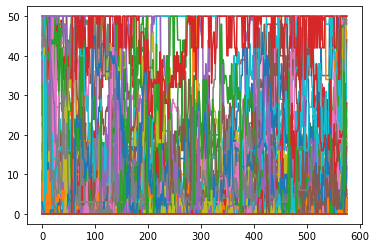

In [722]:
labelizedList = pd.read_csv(CSV_PATH, sep=";")['file']
tearedList = bfun.get_labelized_images_name('Tearing ')

algoTrue = []
algoFalse = []
for i, fileName in enumerate(labelized_list):  
    IMG_PATH = os.path.join(DATASET_PATH, fileName)
    img = Image.open(IMG_PATH)
    #npImg = np.asarray(img, dtype="int32")

    """Histogramme"""
    hist = _histLeftColumn(img)

    """Recherche lignes du tearing"""
    limits, category = _searchH1H2(hist, img)
    if category:
        algoTrue.append(fileName)
    else:
        algoFalse.append(fileName)
        
    print("\r", i,"/", len(labelized_list), fileName, category, end="", flush=True)
#     imgProcessed.append({'fileName': name+".jpg", 'tearingZone': limits, 'category': category})

**Matrice de confusion**

In [725]:
listTP = np.intersect1d(tearedList, algoTrue)
listTN = np.setdiff1d(algoFalse, np.setdiff1d(labelizedList, tearedList))
listFP = np.setdiff1d(algoTrue, tearedList)
listFN = np.intersect1d(tearedList, algoFalse)

true_negative = len(listTN)
true_positive = len(listTP)
false_negative = len(listFN)
false_positive = len(listFP)

matrice = {
    'true' : {
        'negatif': true_negative,
        'positif': true_positive,
    },
     'false' : {
        'negatif': false_negative,
        'positif': false_positive,
    }
}

print("precision:",bfun.precision(matrice=matrice))
print("accuracy:",bfun.accuracy(matrice=matrice))
print("recall:",bfun.recall(matrice=matrice))
print("f1_score:",bfun.f1_score(matrice=matrice))

df = pd.DataFrame(matrice)
df.style


precision: 0.6960227272727273
accuracy: 0.5683168316831683
recall: 0.4268292682926829
f1_score: 0.5291576673866091


,true,false
negatif,329,329
positif,245,107
